# Regression modelling

In this notebook we consider several regression models:
1. Multiple linear regression using only time features (hour, month, holiday)
2. Multiple linear regression using weather and time features (hour, month, holiday)
3. Multiple linear regression with polynomial features

Finally, we will do some feature engineering by categorizing the hour into time of the day () and months into seasons ()

### Importing packages

In [217]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm

from green_city.utils import span, index2datetime
from green_city.plotting import plot_decomposition
from green_city.mlflow_config import get_mlflow_config

import warnings
warnings.filterwarnings('ignore')

RSEED = 42

In [218]:
building_nr = 5
column_to_predict = "net_load_kW"

#document wide parameters that don't change in experiments
#for logging to mlflow server
global_params = {
    "building nr": building_nr,
    "predicted feature": column_to_predict,
    "resolution": "daily",
}

In [219]:
write_data = False

In [220]:
if write_data:
    # ## MLFLOW ##
    try:
        import mlflow
        from green_city.mlflow_config import get_mlflow_config

        flow_conf = get_mlflow_config()
        tracking_uri = flow_conf["TRACKING_URI"]
        mlflow.set_tracking_uri(flow_conf["TRACKING_URI"])
        mlflow.set_experiment(flow_conf["EXPERIMENT_NAME"]);
    except:
        print("mlflow ui not active")


    # ## DB CONNECTION ##
    from sqlalchemy import create_engine
    from decouple import Config, RepositoryEnv

    config = Config(RepositoryEnv("../.db_credentials"))

    db_connection_credentials = {
        "database": config('POSTGRES_DB'),
        "user": config('POSTGRES_USER'),
        "password": config('POSTGRES_PASSWORD'),
        "host": config('POSTGRES_HOST'),
        "port": config('POSTGRES_PORT'),
    }
    DB_STRING = "postgresql://{user}:{password}@{host}:{port}/{database}".format(**db_connection_credentials)
    db = create_engine(DB_STRING)


### Load data

In [221]:
# Load data
df = pd.read_csv(f"../data/preprocessed/Building_{building_nr}.csv").astype({'datetime': 'datetime64'}).set_index('datetime')

In [222]:
# Shift predicted weather values by 24hr
df['pred_24h_diffuse_solar_W_m2_shift'] = df['pred_24h_diffuse_solar_W_m2'].shift(periods=24)
df['pred_24h_direct_solar_W_m2_shift'] = df['pred_24h_direct_solar_W_m2'].shift(periods=24)
df['pred_24h_outdoor_temp_shift'] = df['pred_24h_outdoor_temp'].shift(periods=24)
df['pred_24h_outdoor_hum_shift'] = df['pred_24h_outdoor_hum'].shift(periods=24)
df = df.dropna()

# Extra columns for time features
df['hour'] = df.index.hour
df['month'] = df.index.month
df['year'] = df.index.year

### Correlation matrix

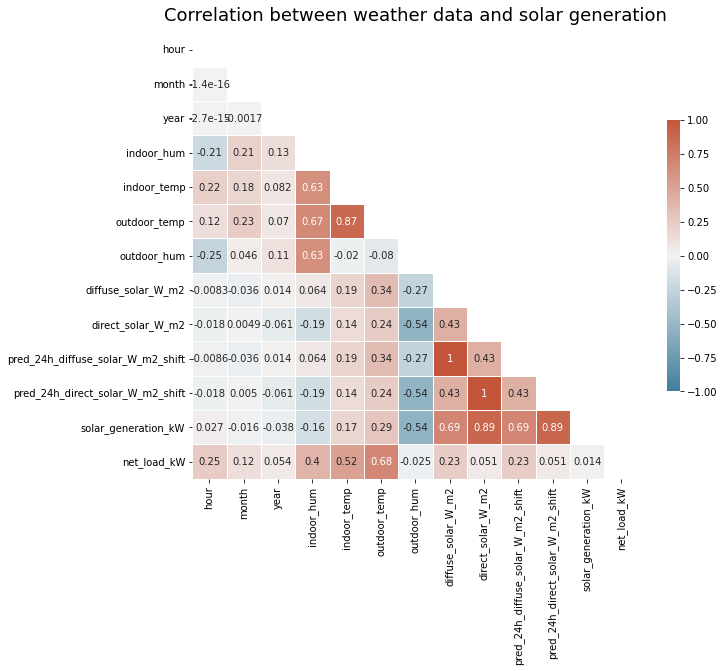

In [223]:
# Correlation matrix
fig, ax = plt.subplots(figsize=(10,10))
corr_weather= df[['hour','month','year','indoor_hum','indoor_temp','outdoor_temp','outdoor_hum', 'diffuse_solar_W_m2', 
                    'direct_solar_W_m2', 'pred_24h_diffuse_solar_W_m2_shift', 
                    'pred_24h_direct_solar_W_m2_shift', 'solar_generation_kW','net_load_kW']].corr()
mask = np.triu(np.ones_like(corr_weather, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
heatmap = sns.heatmap(corr_weather, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)
heatmap.set_title('Correlation between weather data and solar generation', fontdict={'fontsize':18}, pad=12);


In [289]:
# Function for plotting actual vs predicted net energy usage
def plot_ts(actual, predicted, title=None):
    """
    Plots the actual net energy usage against the predicted net energy usage
    """
    fig, ax = plt.subplots(figsize=(12,4))
    actual.plot(ax=ax, label="Actual net usage")
    predicted.plot(ax=ax, label="Predicted net usage")
    plt.xlabel('Date')
    plt.ylabel('Net energy usage [kW]')
    plt.legend()
    plt.title(title)
    plt.show()

## Regression modelling

### 1. Multiple linear regression model using time based features

In [283]:
# Train test split
df_train = df.iloc[:(len(df)-365*24)]   # First 3 years as train data
df_test = df.iloc[(len(df)-365*24):]    # Last year as test data

features = ['hour', 'month', 'year', 'holiday', 'workday']
target = 'net_load_kW'

X = df[features]
y = df[target]

X['hour'] = X['hour'].astype('category')
X['month'] = X['month'].astype('category')
X['year'] = X['year'].astype('category')
X['holiday'] = X['holiday'].astype('category')
X['workday'] = X['workday'].astype('category')
X = pd.get_dummies(X, drop_first=True)

# Train and test split 
# First 3 years is the training data
X_train = X[:(len(X)-365*24)]
y_train = y[:(len(y)-365*24)]

# Last year is the test data
X_test = X[(len(X)-365*24):]
y_test = y[(len(y)-365*24):]

In [284]:
# Fit linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Calculate r-squared for train data
y_pred_train = lin_reg.predict(X_train)
df_train['linreg_time'] = y_pred_train

# Calculate r-squared for test data
y_pred_test = lin_reg.predict(X_test)
df_test['linreg_time'] = y_pred_test

print("----------------------------------------")
print("Linear regression model (time features):")
print("----------------------------------------")
print("R2 (train):", r2_score(y_train, y_pred_train).round(3))
print("R2 (test):", r2_score(y_test, y_pred_test).round(3))
print(f"Mean Absolute Error = {mean_absolute_error(y_test, y_pred_test).round(3)}")
print(f"Mean Squared Error = {mean_squared_error(y_test, y_pred_test).round(3)}")
print(f"Root Mean Squared Error = {np.sqrt(mean_squared_error(y_test, y_pred_test)).round(3)}")

----------------------------------------
Linear regression model (time features):
----------------------------------------
R2 (train): 0.66
R2 (test): 0.518
Mean Absolute Error = 6.086
Mean Squared Error = 59.588
Root Mean Squared Error = 7.719


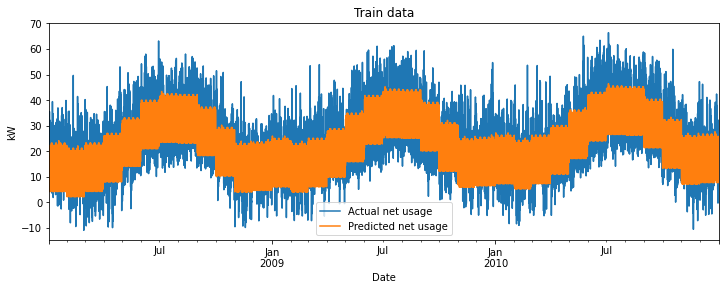

In [285]:
# Plot actual vs predicted train data
plot_ts(df_train['net_load_kW'], df_train['linreg_time'], "Train data")

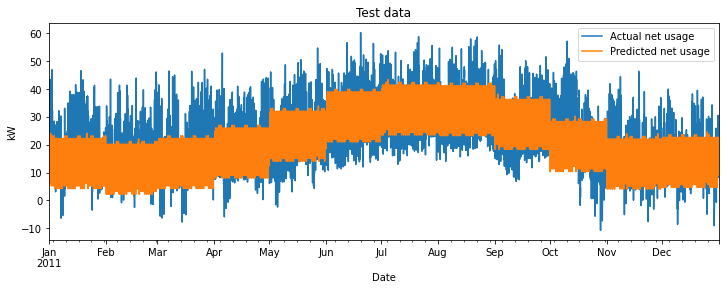

In [286]:
# Plot actual vs predicted test data
plot_ts(df_test['net_load_kW'], df_test['linreg_time'], "Test data")

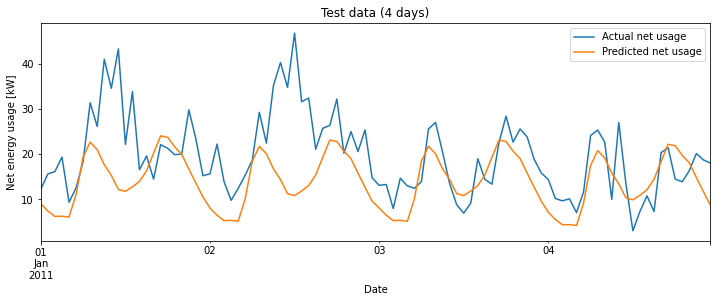

In [290]:
# Plot actual vs predicted test data for 4 days
plot_ts(df_test['net_load_kW'].iloc[0:24*4], df_test['linreg_time'].iloc[0:24*4], "Test data (4 days)")

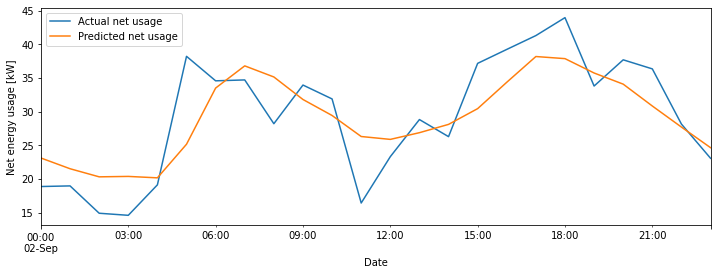

Mean Absolute Error (Linear regression) = 4.039
Mean Squared Error (Linear regression) = 25.025
R2 score (Linear regression) = 0.67
---------------------------------------------


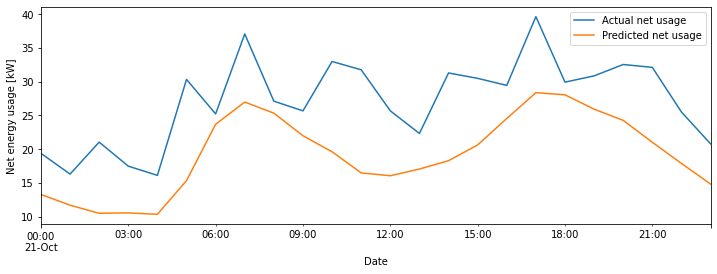

Mean Absolute Error (Linear regression) = 7.851
Mean Squared Error (Linear regression) = 77.527
R2 score (Linear regression) = -0.992
---------------------------------------------


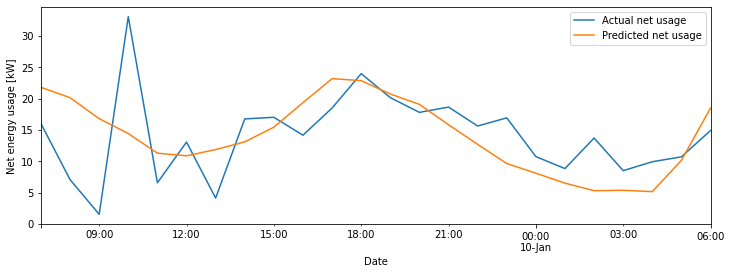

Mean Absolute Error (Linear regression) = 5.167
Mean Squared Error (Linear regression) = 47.476
R2 score (Linear regression) = -0.093
---------------------------------------------


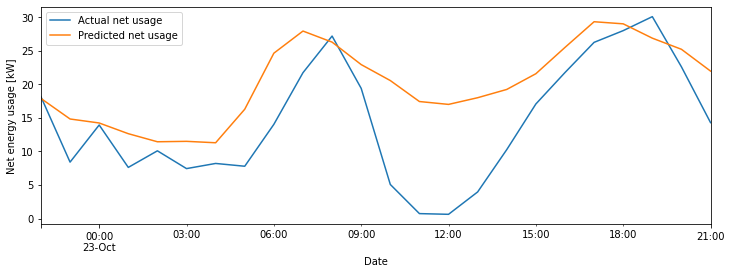

Mean Absolute Error (Linear regression) = 6.15
Mean Squared Error (Linear regression) = 63.141
R2 score (Linear regression) = 0.147
---------------------------------------------


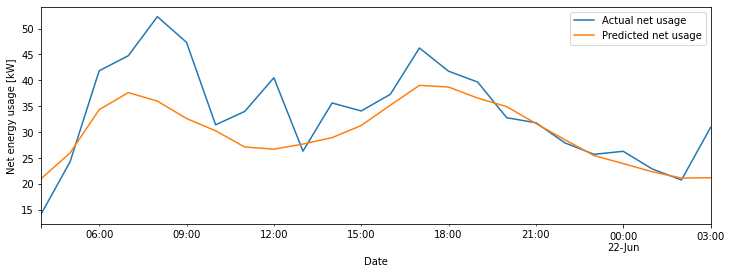

Mean Absolute Error (Linear regression) = 4.934
Mean Squared Error (Linear regression) = 46.311
R2 score (Linear regression) = 0.449
---------------------------------------------


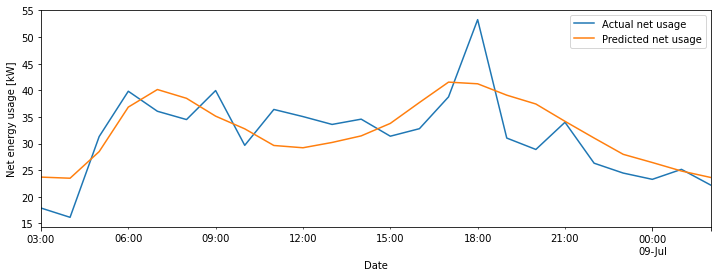

Mean Absolute Error (Linear regression) = 4.417
Mean Squared Error (Linear regression) = 26.551
R2 score (Linear regression) = 0.562
---------------------------------------------


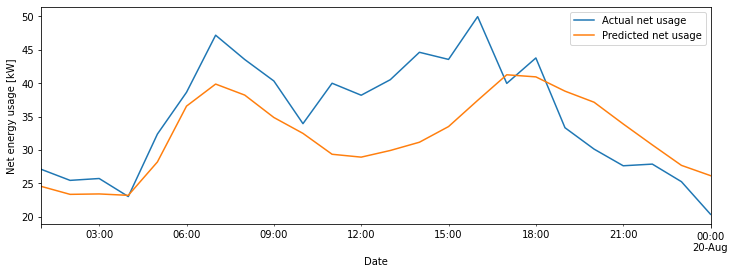

Mean Absolute Error (Linear regression) = 5.555
Mean Squared Error (Linear regression) = 44.83
R2 score (Linear regression) = 0.347
---------------------------------------------


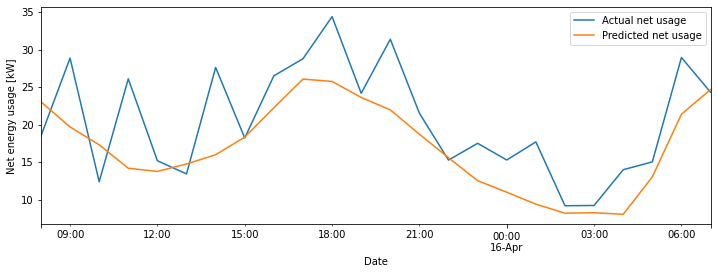

Mean Absolute Error (Linear regression) = 4.549
Mean Squared Error (Linear regression) = 34.103
R2 score (Linear regression) = 0.33
---------------------------------------------


In [292]:
# Randomly chosen list of indices to forecast
pred_indices = [32135, 33311, 26478, 33357, 30387, 30794, 31800, 28783]

forecasts = pd.DataFrame(columns=['prediction','run_id','id'])
for index in pred_indices:

  day = index2datetime(index)

  start_hour = day+pd.DateOffset(hours=1)
  end_hour = day+pd.DateOffset(hours=24)
  forecast_hours = pd.date_range(start=start_hour, end=end_hour, freq='H')
  y_pred = df_test['linreg_time'][df_test.index.isin(forecast_hours)]
  y_test = df_test['net_load_kW'][df_test.index.isin(forecast_hours)]

  # Plot actual vs predicted net energy usage for each of the chosen days
  plot_ts(df_test['net_load_kW'][df_test.index.isin(forecast_hours)], df_test['linreg_time'][df_test.index.isin(forecast_hours)])

  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  print(f"Mean Absolute Error (Linear regression) = {mae.round(3)}")
  print(f"Mean Squared Error (Linear regression) = {mse.round(3)}")
  print(f"R2 score (Linear regression) = {r2.round(3)}")
  print("---------------------------------------------")

  if write_data:
    
    # ##########
    # # MLFLOW #
    # ##########
    # Starting the MLFlow run
    r = mlflow.start_run(run_name="linear_regression_time")
    print("run-uuid:", r.info.run_uuid)

    for k, v in global_params.items():
      mlflow.log_param(k, v)
      mlflow.log_param("model", "linear_regression_time")
      mlflow.log_param("datetime", day)
      mlflow.log_param("feature", "net_load_kW")
      mlflow.log_metric("mse", mse)
      mlflow.log_metric("mae", mae)
      mlflow.log_metric("r2_score", r2)
    mlflow.end_run()
    
    # DataFrame for writing to SQL database
    day_forecast = pd.DataFrame(columns=['prediction','run_id','id'])
    day_forecast['prediction'] = y_pred
    day_forecast['run_id'] = r.info.run_uuid
    day_forecast['id'] = np.arange(index+1,index+25)
    forecasts = pd.concat([forecasts, day_forecast], axis=0)

# Write to SQL DB
if write_data:
  forecasts = forecasts.set_index('id')
  forecasts.to_sql("forecast", con=db, if_exists="append")
  

### 2. Multiple linear regression model using current weather conditions to predict net energy usage

In [294]:
df_train = df.iloc[:(len(df)-365*24)]   # First 3 years as train data
df_test = df.iloc[(len(df)-365*24):]    # Last year as test data

features = ['outdoor_temp', 'outdoor_hum', 'diffuse_solar_W_m2', 'direct_solar_W_m2', 
            'hour', 'month', 'holiday', 'workday']
target = 'net_load_kW'

X = df[features]
y = df[target]

X['hour'] = X['hour'].astype('category')
X['month'] = X['month'].astype('category')
X['holiday'] = X['holiday'].astype('category')
X['workday'] = X['workday'].astype('category')
X = pd.get_dummies(X, drop_first=True)

# Train and test split 
# First 3 years is the training data
X_train = X[:(len(X)-365*24)]
y_train = y[:(len(y)-365*24)]

# Last year is the test data
X_test = X[(len(X)-365*24):]
y_test = y[(len(y)-365*24):]

# Scaling features
cols_to_scale = ['outdoor_temp', 'outdoor_hum', 'diffuse_solar_W_m2', 'direct_solar_W_m2']
scaler = StandardScaler()
X_train_scaled = X_train
X_test_scaled = X_test
X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

In [295]:
# Fit linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Calculate r-squared for train data
y_pred_train = lin_reg.predict(X_train)
df_train['linreg'] = y_pred_train

# Calculate r-squared for test data
y_pred_test = lin_reg.predict(X_test)
df_test['linreg'] = y_pred_test

print("------------------------")
print("Linear regression model:")
print("------------------------")
print("R2 (train):", r2_score(y_train, y_pred_train).round(3))
print("R2 (test):", r2_score(y_test, y_pred_test).round(3))
print(f"Mean Absolute Error = {mean_absolute_error(y_test, y_pred_test).round(3)}")
print(f"Mean Squared Error = {mean_squared_error(y_test, y_pred_test).round(3)}")
print(f"Root Mean Squared Error = {np.sqrt(mean_squared_error(y_test, y_pred_test)).round(3)}")

------------------------
Linear regression model:
------------------------
R2 (train): 0.745
R2 (test): 0.705
Mean Absolute Error = 4.745
Mean Squared Error = 36.463
Root Mean Squared Error = 6.038


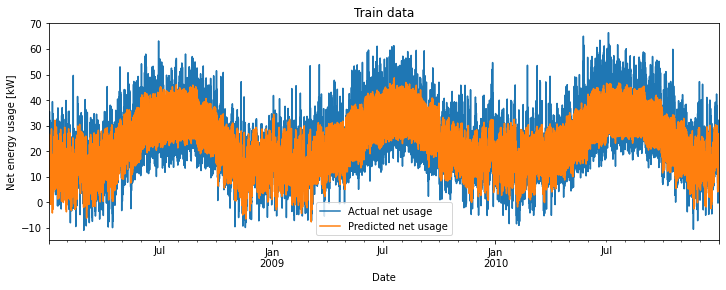

In [296]:
# Plot actual vs predicted train data
plot_ts(df_train['net_load_kW'], df_train['linreg'], "Train data")

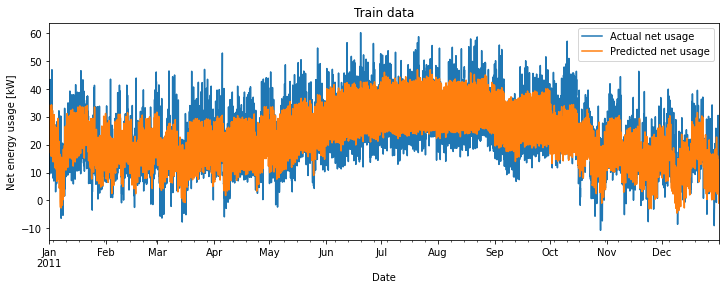

In [297]:
# Plot actual vs predicted train data
plot_ts(df_test['net_load_kW'], df_test['linreg'], "Train data")

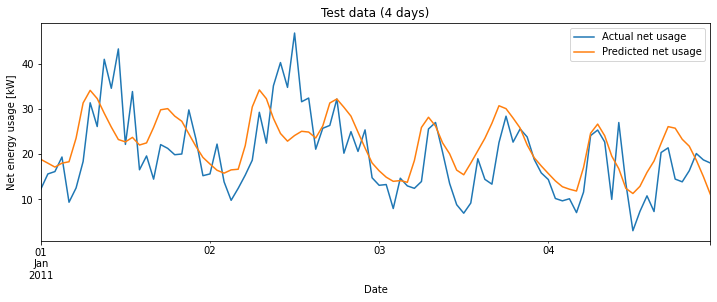

In [298]:
# Plot actual vs predicted train data
plot_ts(df_test['net_load_kW'].iloc[0:24*4], df_test['linreg'].iloc[0:24*4], "Test data (4 days)")

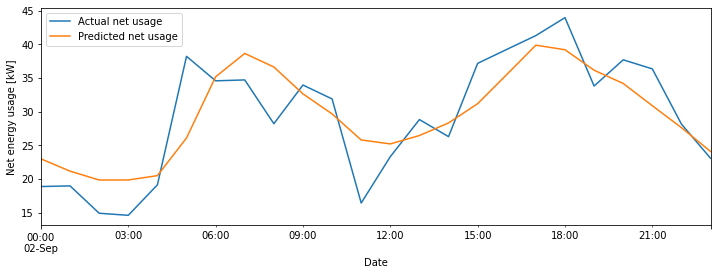

Mean Absolute Error (Linear regression) = 3.791
Mean Squared Error (Linear regression) = 22.558
Root Mean Squared Error (Linear regression) = 4.749
R2 score (Linear regression) = 0.703
---------------------------------------------


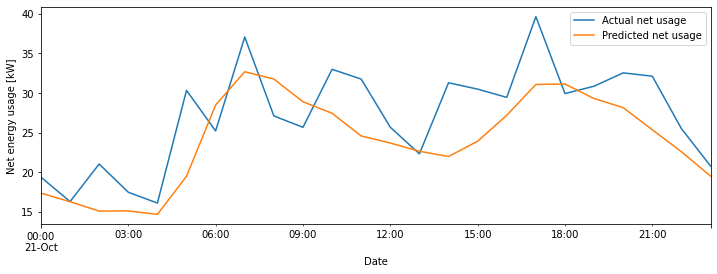

Mean Absolute Error (Linear regression) = 4.081
Mean Squared Error (Linear regression) = 24.993
Root Mean Squared Error (Linear regression) = 4.999
R2 score (Linear regression) = 0.358
---------------------------------------------


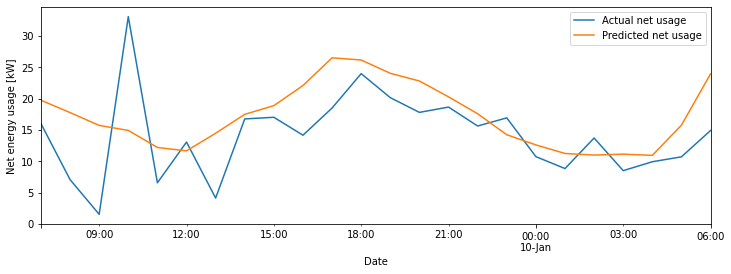

Mean Absolute Error (Linear regression) = 5.2
Mean Squared Error (Linear regression) = 46.743
Root Mean Squared Error (Linear regression) = 6.837
R2 score (Linear regression) = -0.076
---------------------------------------------


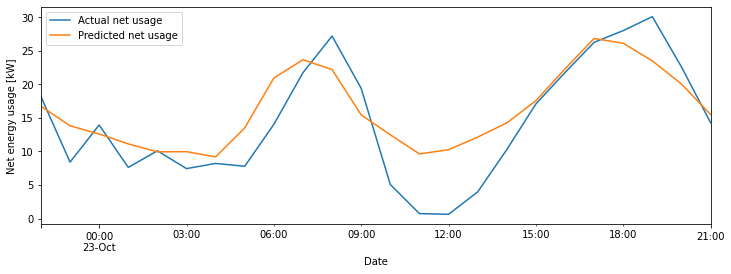

Mean Absolute Error (Linear regression) = 3.778
Mean Squared Error (Linear regression) = 22.58
Root Mean Squared Error (Linear regression) = 4.752
R2 score (Linear regression) = 0.695
---------------------------------------------


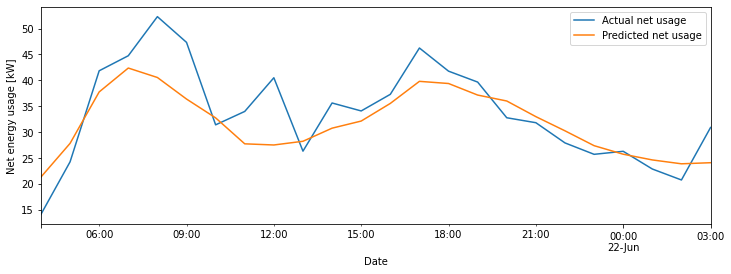

Mean Absolute Error (Linear regression) = 4.286
Mean Squared Error (Linear regression) = 30.005
Root Mean Squared Error (Linear regression) = 5.478
R2 score (Linear regression) = 0.643
---------------------------------------------


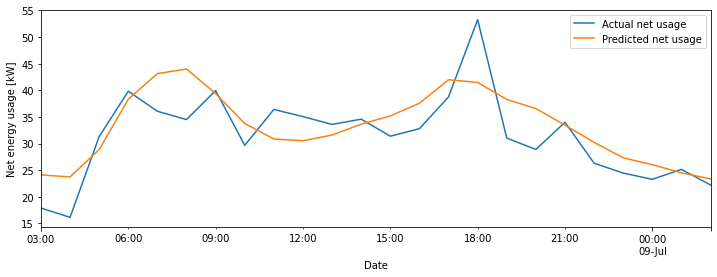

Mean Absolute Error (Linear regression) = 4.261
Mean Squared Error (Linear regression) = 26.994
Root Mean Squared Error (Linear regression) = 5.196
R2 score (Linear regression) = 0.555
---------------------------------------------


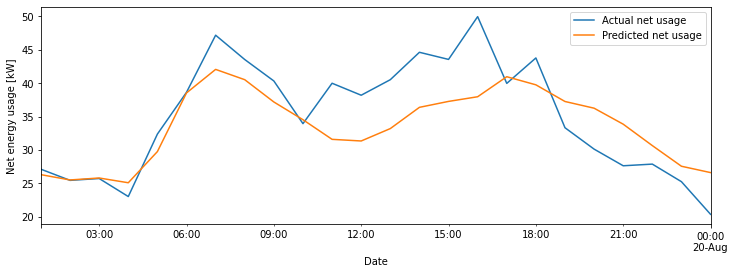

Mean Absolute Error (Linear regression) = 4.133
Mean Squared Error (Linear regression) = 26.628
Root Mean Squared Error (Linear regression) = 5.16
R2 score (Linear regression) = 0.612
---------------------------------------------


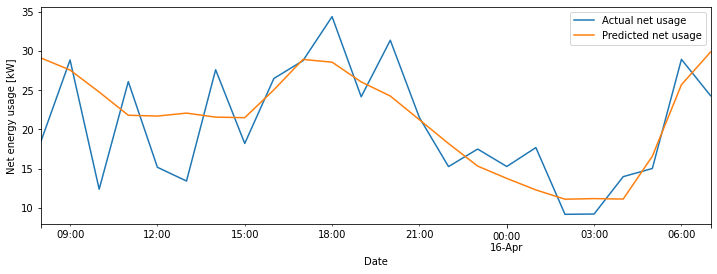

Mean Absolute Error (Linear regression) = 4.123
Mean Squared Error (Linear regression) = 26.934
Root Mean Squared Error (Linear regression) = 5.19
R2 score (Linear regression) = 0.471
---------------------------------------------


In [300]:
# Randomly chosen list of indices to forecast
pred_indices = [32135, 33311, 26478, 33357, 30387, 30794, 31800, 28783]

forecasts = pd.DataFrame(columns=['prediction','run_id','id'])
for index in pred_indices:

  day = index2datetime(index)

  start_hour = day+pd.DateOffset(hours=1)
  end_hour = day+pd.DateOffset(hours=24)
  forecast_hours = pd.date_range(start=start_hour, end=end_hour, freq='H')
  y_pred = df_test['linreg'][df_test.index.isin(forecast_hours)]
  y_test = df_test['net_load_kW'][df_test.index.isin(forecast_hours)]

  # Plot actual vs predicted net energy usage for each of the chosen days
  plot_ts(df_test['net_load_kW'][df_test.index.isin(forecast_hours)], df_test['linreg'][df_test.index.isin(forecast_hours)])

  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  print(f"Mean Absolute Error (Linear regression) = {mae.round(3)}")
  print(f"Mean Squared Error (Linear regression) = {mse.round(3)}")
  print(f"Root Mean Squared Error (Linear regression) = {np.sqrt(mse).round(3)}")
  print(f"R2 score (Linear regression) = {r2.round(3)}")
  print("---------------------------------------------")

  if write_data:
    
    # ##########
    # # MLFLOW #
    # ##########
    # Starting the MLFlow run
    r = mlflow.start_run(run_name="linear_regression")
    print("run-uuid:", r.info.run_uuid)

    for k, v in global_params.items():
      mlflow.log_param(k, v)
      mlflow.log_param("model", "linear_regression")
      mlflow.log_param("datetime", day)
      mlflow.log_param("feature", "net_load_kW")
      mlflow.log_metric("mse", mse)
      mlflow.log_metric("mae", mae)
      mlflow.log_metric("r2_score", r2)
    mlflow.end_run()
    
    # DataFrame for writing to SQL database
    day_forecast = pd.DataFrame(columns=['prediction','run_id','id'])
    day_forecast['prediction'] = y_pred
    day_forecast['run_id'] = r.info.run_uuid
    day_forecast['id'] = np.arange(index+1,index+25)
    forecasts = pd.concat([forecasts, day_forecast], axis=0)

# Write to SQL DB
if write_data:
  forecasts = forecasts.set_index('id')
  forecasts.to_sql("forecast", con=db, if_exists="append")
  

### 3. Multiple linear regression model with 2 polynomial features using current weather conditions

In [301]:
df_train = df.iloc[:(len(df)-365*24)]   # First 3 years as train data
df_test = df.iloc[(len(df)-365*24):]    # Last year as test data

features = ['outdoor_temp', 'outdoor_hum', 'diffuse_solar_W_m2', 'direct_solar_W_m2', 
            'hour', 'month', 'holiday', 'workday']
target = 'net_load_kW'

X = df[features]
y = df[target]

# Dummy variables
dummy_features = ['hour','month','holiday','workday']
for col in dummy_features:
    X[col] = X[col].astype('category')
X = pd.get_dummies(X, drop_first=True)

# Train and test split 
X_train = X[:(len(X)-365*24)]   # First 3 years
y_train = y[:(len(y)-365*24)]

X_test = X[(len(X)-365*24):]    # Last year
y_test = y[(len(y)-365*24):]

# Scaling features
cols_to_scale = ['outdoor_temp', 'outdoor_hum', 'diffuse_solar_W_m2', 'direct_solar_W_m2']
scaler = StandardScaler()
X_train_scaled = X_train
X_test_scaled = X_test
X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

In [302]:
# here we will add the second degree polynomial features
n=2
polynomial_features = PolynomialFeatures(degree=n, include_bias=False)
x_poly_train = polynomial_features.fit_transform(X_train)   # Transform training x-data
x_poly_test = polynomial_features.transform(X_test)         # Transform test x-data

model_poly = LinearRegression() # Do linear regression
model_poly.fit(x_poly_train, y_train)
y_pred_test = model_poly.predict(x_poly_test)
y_pred_train = model_poly.predict(x_poly_train)

df_train['linreg_with_poly'] = y_pred_train
df_test['linreg_with_poly'] = y_pred_test

print("n:", n," R-squared (train):", r2_score(y_train, y_pred_train).round(3))
print("n:", n," R-squared (test):", r2_score(y_test, y_pred_test).round(3))

mae_poly = mean_absolute_error(y_test, y_pred_test).round(3)
mse_poly = mean_squared_error(y_test, y_pred_test).round(3)
print(f"Mean Absolute Error = {mae_poly}")
print(f"Mean Squared Error = {mse_poly}")

print("MAPE =", mean_absolute_percentage_error(y_test, y_pred_test).round(3))

n: 2  R-squared (train): 0.873
n: 2  R-squared (test): 0.839
Mean Absolute Error = 3.328
Mean Squared Error = 19.94
MAPE = 139.287


### Using previously trained model to forecast net energy usage

In [303]:
df_train = df.iloc[:(len(df)-365*24)]   # First 3 years as train data
df_test = df.iloc[(len(df)-365*24):]    # Last year as test data

fc_features = ['pred_24h_outdoor_temp_shift', 'pred_24h_outdoor_hum_shift', 
                'pred_24h_diffuse_solar_W_m2_shift', 'pred_24h_direct_solar_W_m2_shift', 
                'hour', 'month', 'holiday', 'workday']
target = 'net_load_kW'

X_fc = df[fc_features]
y_fc = df[target]

# Dummy variables
fc_dummy_features = ['hour','month','holiday','workday']
for col in fc_dummy_features:
    X_fc[col] = X_fc[col].astype('category')
X_fc = pd.get_dummies(X_fc, drop_first=True)

# Train and test split 
# First 3 years is the training data
X_fc_train = X_fc[:(len(X_fc)-365*24)]
y_fc_train = y_fc[:(len(y_fc)-365*24)]

# Last year is the test data
X_fc_test = X_fc[(len(X)-365*24):]
y_fc_test = y_fc[(len(y)-365*24):]

# Scaling features
fc_cols_to_scale = ['pred_24h_outdoor_temp_shift', 'pred_24h_outdoor_hum_shift', 
                    'pred_24h_diffuse_solar_W_m2_shift', 'pred_24h_direct_solar_W_m2_shift']
X_fc_train_scaled = X_fc_train
X_fc_test_scaled = X_fc_test
X_fc_train_scaled[fc_cols_to_scale] = scaler.transform(X_fc_train[fc_cols_to_scale])
X_fc_test_scaled[fc_cols_to_scale] = scaler.transform(X_fc_test[fc_cols_to_scale])

In [305]:
# here we will add the second degree polynomial features
n=2
x_poly_fc_train = polynomial_features.transform(X_fc_train_scaled) # Transform training x-data
x_poly_fc_test = polynomial_features.transform(X_fc_test_scaled)   # Transform test x-data

# Predict using already trained model
y_pred_fc_train = model_poly.predict(x_poly_fc_train)
y_pred_fc_test = model_poly.predict(x_poly_fc_test)

df_train['linreg_poly'] = y_pred_fc_train
df_test['linreg_poly'] = y_pred_fc_test

print("n:", n," R-squared (train):", r2_score(y_train, y_pred_fc_train).round(3))
print("n:", n," R-squared (test):", r2_score(y_test, y_pred_fc_test).round(3))

mae_poly = mean_absolute_error(y_test, y_pred_fc_test).round(3)
mse_poly = mean_squared_error(y_test, y_pred_fc_test).round(3)
print(f"Mean Absolute Error = {mae_poly}")
print(f"Mean Squared Error = {mse_poly}")

print("MAPE =", mean_absolute_percentage_error(y_test, y_pred_fc_test).round(3))

n: 2  R-squared (train): 0.863
n: 2  R-squared (test): 0.829
Mean Absolute Error = 3.455
Mean Squared Error = 21.129
MAPE = 133.995


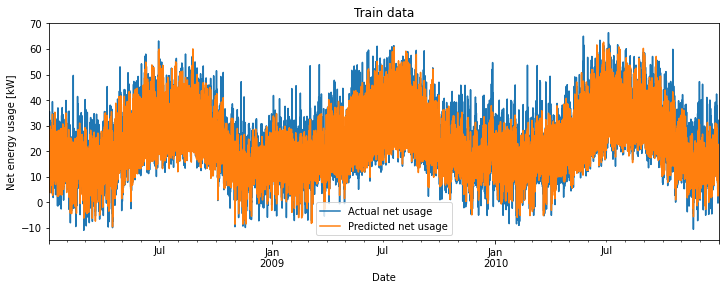

In [313]:
plot_ts(df_train['net_load_kW'], df_train['linreg_poly'], "Train data")

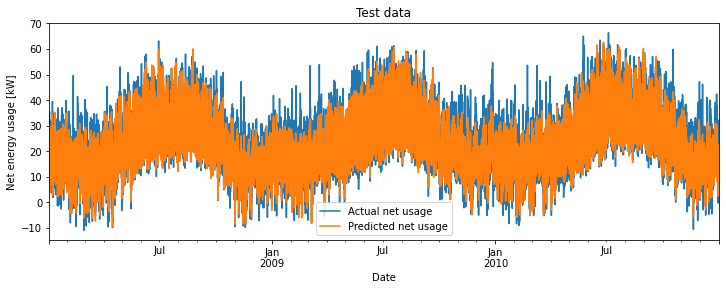

In [314]:
plot_ts(df_train['net_load_kW'], df_train['linreg_poly'], "Test data")

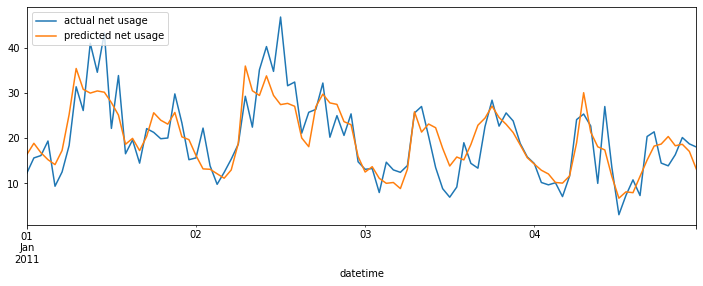

In [308]:
fig, ax = plt.subplots(figsize=(12,4))
df_test['net_load_kW'].iloc[0:24*4].plot(label="actual net usage")
df_test['linreg_poly'].iloc[0:24*4].plot(label="predicted net usage")
plt.legend(loc='upper left')
plt.show()

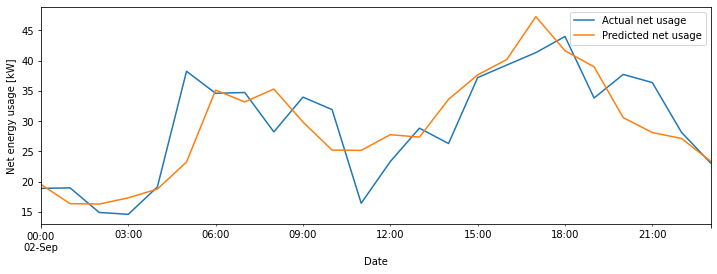

Mean Absolute Error (Linear regression) = 4.006
Mean Squared Error (Linear regression) = 28.985
Root Mean Squared Error (Linear regression) = 5.384
R2 score (Linear regression) = 0.618
---------------------------------------------


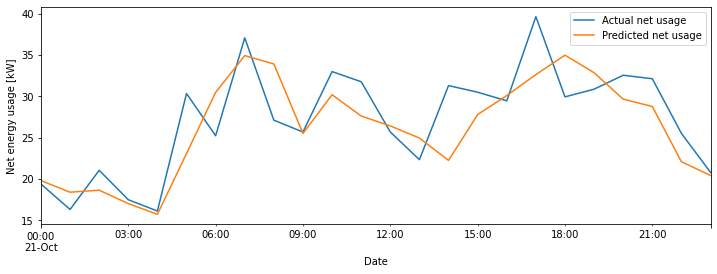

Mean Absolute Error (Linear regression) = 3.092
Mean Squared Error (Linear regression) = 15.596
Root Mean Squared Error (Linear regression) = 3.949
R2 score (Linear regression) = 0.599
---------------------------------------------


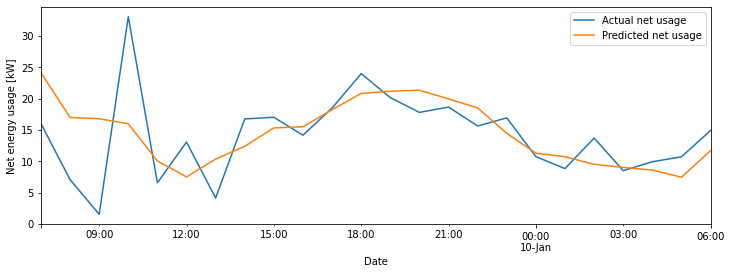

Mean Absolute Error (Linear regression) = 4.277
Mean Squared Error (Linear regression) = 36.637
Root Mean Squared Error (Linear regression) = 6.053
R2 score (Linear regression) = 0.157
---------------------------------------------


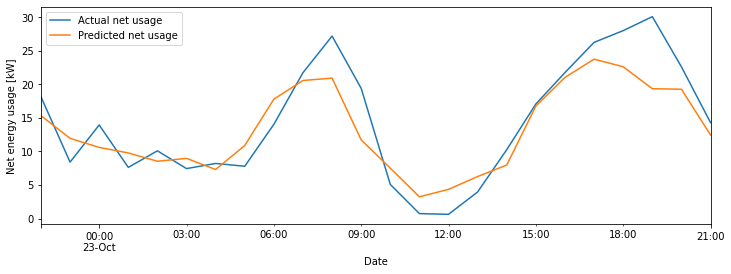

Mean Absolute Error (Linear regression) = 3.16
Mean Squared Error (Linear regression) = 15.295
Root Mean Squared Error (Linear regression) = 3.911
R2 score (Linear regression) = 0.793
---------------------------------------------


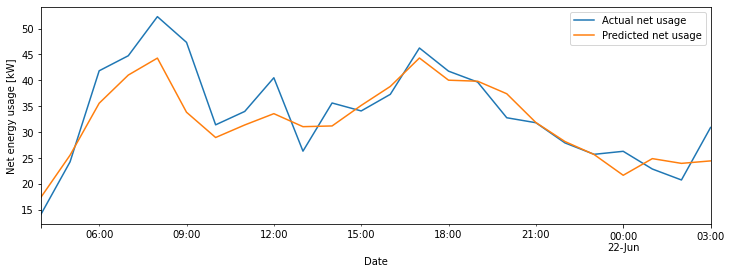

Mean Absolute Error (Linear regression) = 3.536
Mean Squared Error (Linear regression) = 21.791
Root Mean Squared Error (Linear regression) = 4.668
R2 score (Linear regression) = 0.741
---------------------------------------------


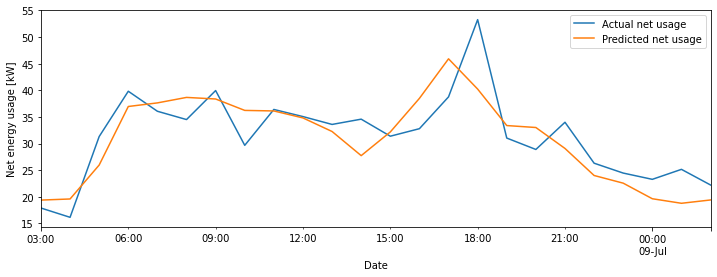

Mean Absolute Error (Linear regression) = 3.781
Mean Squared Error (Linear regression) = 22.313
Root Mean Squared Error (Linear regression) = 4.724
R2 score (Linear regression) = 0.632
---------------------------------------------


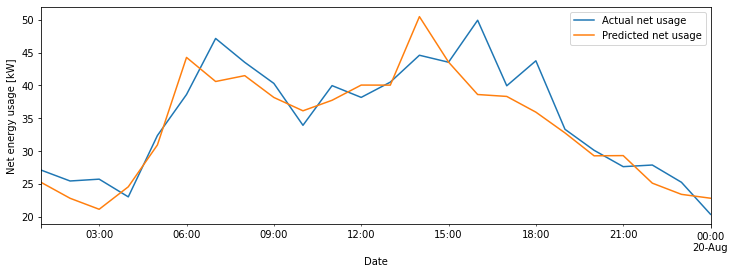

Mean Absolute Error (Linear regression) = 2.999
Mean Squared Error (Linear regression) = 15.839
Root Mean Squared Error (Linear regression) = 3.98
R2 score (Linear regression) = 0.769
---------------------------------------------


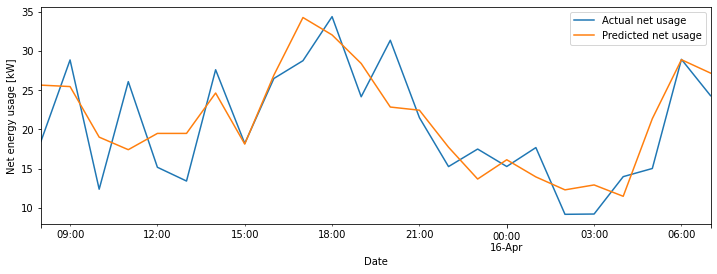

Mean Absolute Error (Linear regression) = 3.783
Mean Squared Error (Linear regression) = 20.335
Root Mean Squared Error (Linear regression) = 4.509
R2 score (Linear regression) = 0.6
---------------------------------------------


In [310]:
# Randomly chosen list of indices to forecast
pred_indices = [32135, 33311, 26478, 33357, 30387, 30794, 31800, 28783]

forecasts = pd.DataFrame(columns=['prediction','run_id','id'])
for index in pred_indices:

  day = index2datetime(index)

  start_hour = day+pd.DateOffset(hours=1)
  end_hour = day+pd.DateOffset(hours=24)
  forecast_hours = pd.date_range(start=start_hour, end=end_hour, freq='H')
  y_pred = df_test['linreg_poly'][df_test.index.isin(forecast_hours)]
  y_test = df_test['net_load_kW'][df_test.index.isin(forecast_hours)]

  # Plot actual vs predicted net energy usage for each of the chosen days
  plot_ts(df_test['net_load_kW'][df_test.index.isin(forecast_hours)], df_test['linreg_poly'][df_test.index.isin(forecast_hours)])

  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  print(f"Mean Absolute Error (Linear regression) = {mae.round(3)}")
  print(f"Mean Squared Error (Linear regression) = {mse.round(3)}")
  print(f"Root Mean Squared Error (Linear regression) = {np.sqrt(mse).round(3)}")
  print(f"R2 score (Linear regression) = {r2.round(3)}")
  print("---------------------------------------------")

  if write_data:
    
    # ##########
    # # MLFLOW #
    # ##########
    # Starting the MLFlow run
    r = mlflow.start_run(run_name="linear_regression_poly")
    print("run-uuid:", r.info.run_uuid)

    for k, v in global_params.items():
      mlflow.log_param(k, v)
      mlflow.log_param("model", "linear_regression_poly")
      mlflow.log_param("datetime", day)
      mlflow.log_param("feature", "net_load_kW")
      mlflow.log_metric("mse", mse)
      mlflow.log_metric("mae", mae)
      mlflow.log_metric("r2_score", r2)
    mlflow.end_run()
    
    # DataFrame for writing to SQL database
    day_forecast = pd.DataFrame(columns=['prediction','run_id','id'])
    day_forecast['prediction'] = y_pred
    day_forecast['run_id'] = r.info.run_uuid
    day_forecast['id'] = np.arange(index+1,index+25)
    forecasts = pd.concat([forecasts, day_forecast], axis=0)

# Write to SQL DB
if write_data:
  forecasts = forecasts.set_index('id')
  forecasts.to_sql("forecast", con=db, if_exists="append")
  

## Feature engineering

Instead of treating each hour and each month as individual category, we group them since certain hours of the day should have similar energy usage patterns.

In [311]:
# Group months into seasons
def seasons(x):
    if x in [12,1,2]:
        return 'winter'
    elif x in [3,4,5]:
        return 'spring'
    elif x in [6,7,8]:
        return 'summer'
    elif x in [9,10,11]:
        return 'autumn'

In [312]:
# Group hours into morning, afternoon, evening or night
def time_of_day(x):
    if x in [7, 8, 9, 10, 11]:
        return 'morning'
    elif x in [12, 13, 14, 15, 16]:
        return 'afternoon'
    elif x in [17, 18, 19, 20, 21]:
        return 'evening'
    elif x in [22, 23, 0, 1, 2, 3, 4, 5, 6]:
        return 'night'

In [122]:
df['season'] = df['month'].apply(seasons)
df['season'] = df['season'].astype('category')

df['time_of_day'] = df['hour'].apply(time_of_day)
df['time_of_day'] = df['time_of_day'].astype('category')

df['day_of_week'] = df.index.day_of_week

In [145]:
df_train = df.iloc[:(len(df)-365*24)]   # First 3 years as train data
df_test = df.iloc[(len(df)-365*24):]    # Last year as test data

# Define features and target variables
features = ['outdoor_temp', 'outdoor_hum', 'diffuse_solar_W_m2', 'direct_solar_W_m2', 
            'season', 'time_of_day', 'holiday', 'day_of_week']
target = 'net_load_kW'

X = df[features]
y = df[target]

X['season'] = X['season'].astype('category')
X['time_of_day'] = X['time_of_day'].astype('category')
X['holiday'] = X['holiday'].astype('category')
X['day_of_week'] = X['day_of_week'].astype('category')
X = pd.get_dummies(X, drop_first=True)

# Train and test split 
# First 3 years is the training data
X_train = X[:(len(X)-365*24)]
y_train = y[:(len(y)-365*24)]

# Last year is the test data
X_test = X[(len(X)-365*24):]
y_test = y[(len(y)-365*24):]

# Scaling features
cols_to_scale = ['outdoor_temp', 'outdoor_hum', 'diffuse_solar_W_m2', 'direct_solar_W_m2']
scaler = StandardScaler()
X_train_scaled = X_train
X_test_scaled = X_test
X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

In [146]:
# Fit linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Calculate r-squared for train data
y_pred_train = lin_reg.predict(X_train)
df_train['net_load_kW_lin_forecast'] = y_pred_train

# Calculate r-squared for test data
y_pred_test = lin_reg.predict(X_test)
df_test['net_load_kW_lin_forecast'] = y_pred_test

print("------------------------")
print("Linear regression model:")
print("------------------------")
print("R2 (train):", r2_score(y_train, y_pred_train).round(3))
print("R2 (test):", r2_score(y_test, y_pred_test).round(3))
print(f"Mean Absolute Error = {mean_absolute_error(y_test, y_pred_test).round(3)}")
print(f"Mean Squared Error = {mean_squared_error(y_test, y_pred_test).round(3)}")
print(f"Root Mean Squared Error = {np.sqrt(mean_squared_error(y_test, y_pred_test)).round(3)}")

------------------------
Linear regression model:
------------------------
R2 (train): 0.621
R2 (test): 0.592
Mean Absolute Error = 5.532
Mean Squared Error = 50.494
Root Mean Squared Error = 7.106


In [148]:
# here we will add the second degree polynomial features
n=2
polynomial_features = PolynomialFeatures(degree=n, include_bias=False)
x_poly_train = polynomial_features.fit_transform(X_train_scaled)   # Transform training x-data
x_poly_test = polynomial_features.transform(X_test_scaled)         # Transform test x-data

model_poly = LinearRegression() # Do linear regression
model_poly.fit(x_poly_train, y_train)
y_pred_test = model_poly.predict(x_poly_test)
y_pred_train = model_poly.predict(x_poly_train)

df_train['net_load_kW_poly_forecast'] = y_pred_train
df_test['net_load_kW_poly_forecast'] = y_pred_test

print("n:", n," R-squared (train):", r2_score(y_train, y_pred_train).round(3))
print("n:", n," R-squared (test):", r2_score(y_test, y_pred_test).round(3))

mae_poly = mean_absolute_error(y_test, y_pred_test).round(3)
mse_poly = mean_squared_error(y_test, y_pred_test).round(3)
print(f"Mean Absolute Error = {mae_poly}")
print(f"Mean Squared Error = {mse_poly}")

print("MAPE =", mean_absolute_percentage_error(y_test, y_pred_test).round(3))

n: 2  R-squared (train): 0.828
n: 2  R-squared (test): 0.791
Mean Absolute Error = 3.845
Mean Squared Error = 25.825
MAPE = 124.604
